In [ ]:
import os
import sys
import numpy as np
import sympy as sp
import torch as pt
from torch.nn.functional import normalize
import scipy
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import logging
import sys
from torch.utils.data import TensorDataset, DataLoader
from torch.func import hessian, vmap
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

from src.useful_functions import *
from src.data_modules.PWDs_module import generate_PWDistances_torch
from src.data_modules.sqra_functions import*
from src.data_modules.openmm_functions import*
from src.isokann.isokann_module_schnet import*
# For reproducibility
np.random.seed(0)


# Read directory paths
read_dirs_paths('../dir_paths.txt', globals())



 
Created variables:
inp_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/input/
dcd_dir = /scratch/htc/fsafarov/2cm2_simulation/md2/output/trajectories/openmm_files
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/


In [2]:
forces = pt.load(os.path.join(out_dir, '8g65_force_components.pt'))
positions = pt.load(os.path.join(out_dir, '8g65_coords.pt'))

In [3]:
n_samples = positions.shape[0]
n_particles = positions.shape[-2]

In [4]:
atomic_numbers = pt.ones(( n_samples, n_particles,1)).long()


In [5]:
from torch_geometric.nn.models import SchNet

In [6]:
base_model = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )

In [7]:
model = ratesNN(base_model)
optimizer = pt.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = pt.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5, momentum=0.85, nesterov=True)
# optimizer = pt.optim.Adam([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5)
# optimizer = pt.optim.SGD([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5, momentum=0.85, nesterov=True)
# D=2.5                    

c1_vals, c2_vals = trainNN(
    model=model, 
    coords=positions.to(device), 
    forces_fn=forces.to(device),
    atomic_numbers=atomic_numbers.to(device), 
    batch_size=500,
    optimizer=optimizer, 
    Nepochs=1000,
    lam_bound=0.1,
    device=device
)

epoch   0 | loss 0.007433 |
epoch 125 | loss 0.000013 |
epoch 250 | loss 0.000009 |
epoch 375 | loss 0.000009 |
epoch 500 | loss 0.000009 |
epoch 625 | loss 0.000009 |
epoch 750 | loss 0.000010 |
epoch 875 | loss 0.000008 |
epoch 1000 | loss 0.000009 |


In [8]:
# # Move a small sample to the same device as the model
# sample_xb = positions[:5].to(device).float()
# sample_zb = atomic_numbers[:5].to(device).long()
# sample_batch_dims = get_batch_dimensions(5, n_particles).to(device)

# model.eval()
# with pt.no_grad():
#     # Access the raw SchNet output (logits)
#     raw_logits = model.net(
#         sample_zb.reshape(-1), 
#         sample_xb.reshape(-1, 3), 
#         sample_batch_dims
#     )
    
# print(f"--- Logit Diagnostics ---")
# print(f"Min logit: {raw_logits.min().item():.4f}")
# print(f"Max logit: {raw_logits.max().item():.4f}")
# print(f"Mean logit: {raw_logits.mean().item():.4f}")
# print(f"Std dev: {raw_logits.std().item():.4f}")

In [9]:
def get_batch_dimensions(batch_size, n_particles):
    return pt.repeat_interleave(pt.arange(batch_size), n_particles)

n_particles = positions.shape[-2]
n_samples = positions.shape[0]
batch_dims = get_batch_dimensions(n_samples, n_particles).to(device)

In [10]:
with pt.no_grad():
    chi = model(atomic_numbers.reshape(-1).to(device), positions.reshape(-1,3).to(device), batch_dims)

In [11]:
def scale_and_shift(y):
    minarr = pt.min(y)
    maxarr = pt.max(y)
    hat_y =  (y - minarr) / (maxarr - minarr)

    return hat_y

chi_s = scale_and_shift(chi)
chi_s = chi_s.cpu().detach().numpy()

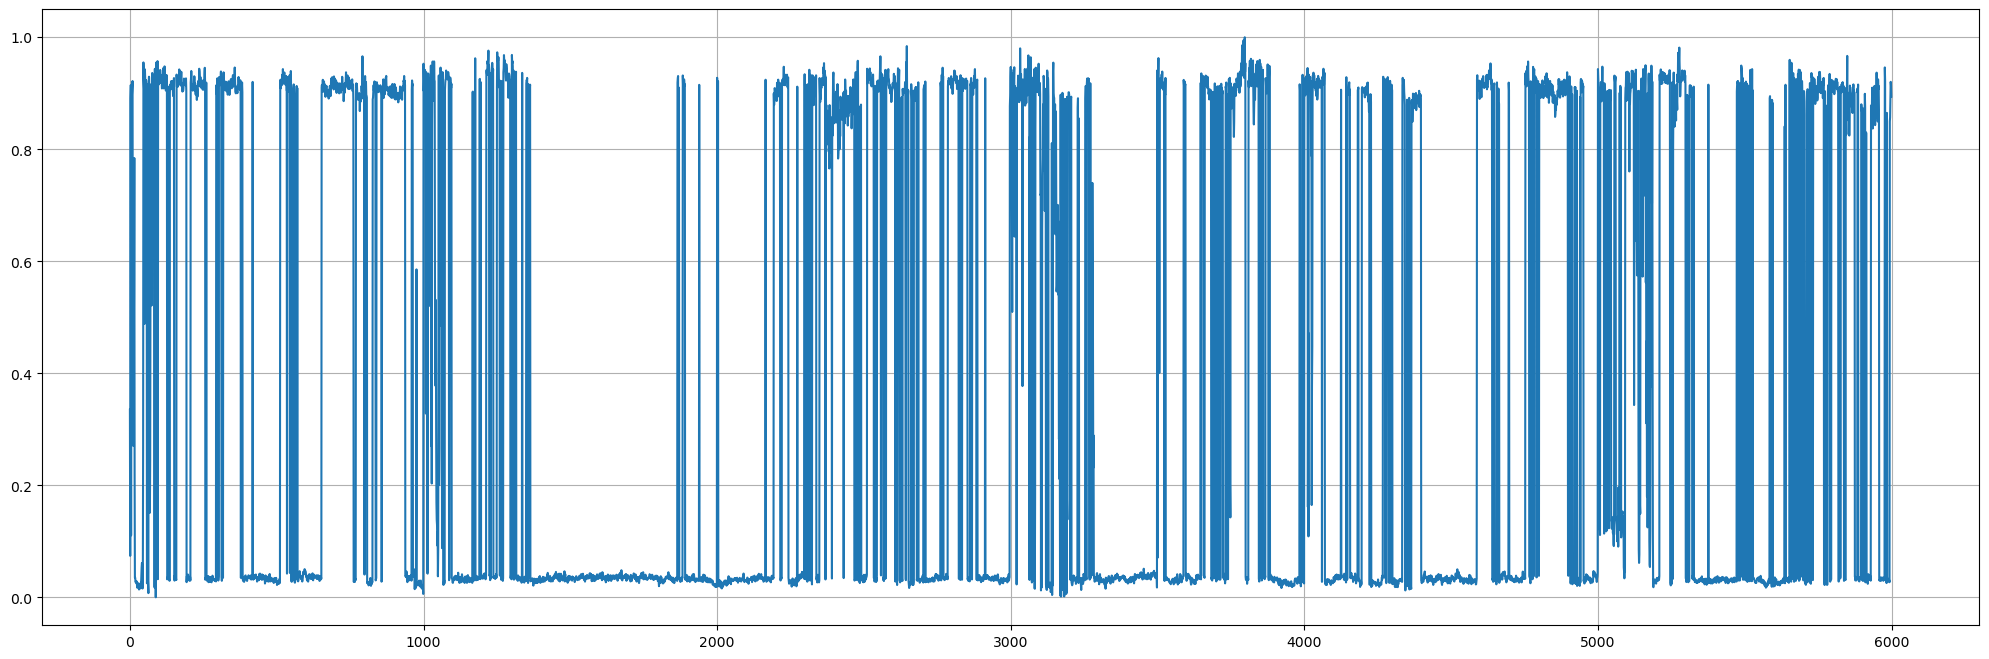

In [12]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(25,8))
plt.plot(chi_s)
plt.grid()

In [13]:
np.savetxt(os.path.join(out_dir, '8g65_gnn_chi_0.txt'), chi_s)

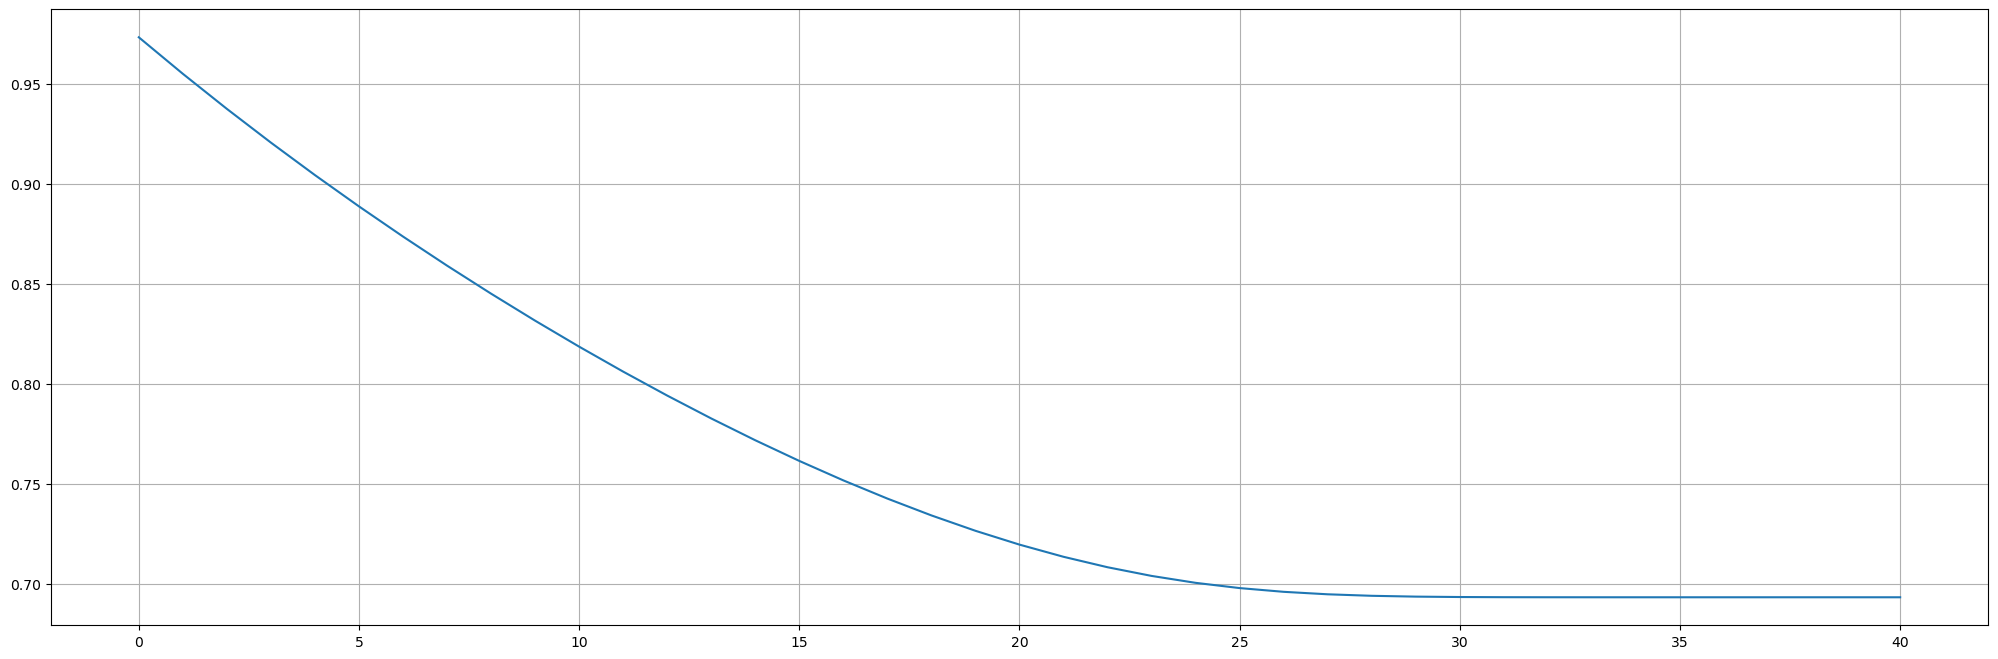

In [14]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(25,8))
plt.plot(c2_vals)
plt.grid()

In [15]:
del forces
del positions

In [16]:
del model

In [17]:
chi0 = np.loadtxt('/scratch/htc/fsafarov/2cm2_simulation/md2/output/isokann/outs_38/' + 'chi0_lr.txt')
chi_m = np.array([chi0, chi_s.flatten()])

In [18]:
from scipy.linalg import svd
U, S, V = svd(chi_m)

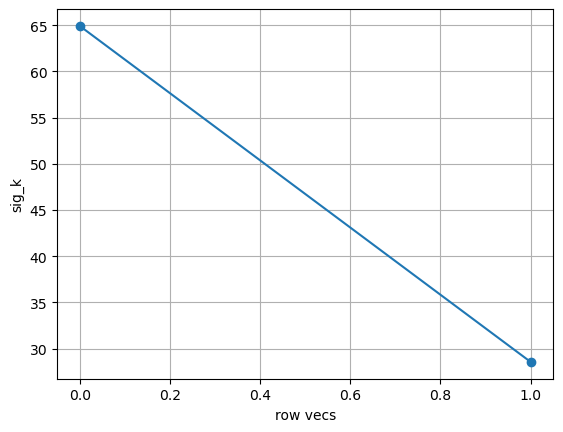

In [19]:
plt.plot(S, 'o-')
plt.xlabel('row vecs')
plt.ylabel('sig_k')
plt.grid()

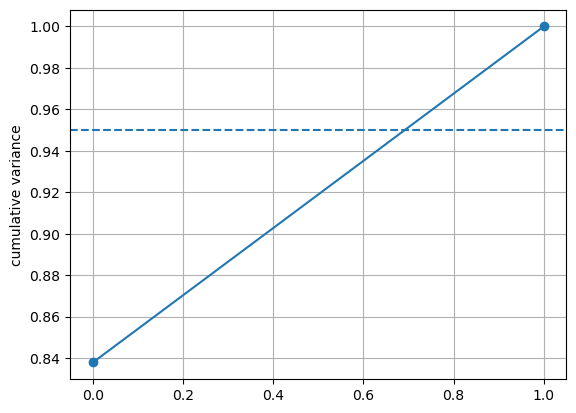

In [20]:
varfrac = (S**2)/np.sum(S**2)
plt.plot(np.cumsum(varfrac), 'o-'); plt.axhline(0.95, ls='--')
plt.ylabel('cumulative variance')
plt.grid()